# Try GP model

Started: May, 8 2020.

- Alternatively we could use a multilayer preceptron with MC-Dropout (following Yarin Gal), but there is some discussion about what this acutally measures (for this reason I now also moved back to GP for some of my projects).

In [113]:
import os 

import pandas as pd 
import numpy as np 
import GPy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import joblib

import matplotlib.pyplot as plt 
%matplotlib inline 

DATADIR = '../data'
TRAIN_SIZE = 0.7

import sys
sys.path.append('..')
from dispersant_screener.definitions import *

## Load the data

- For the startification we need to look into it.

In [6]:
df_full_factorial = pd.read_csv(os.path.join(DATADIR, 'full_fact.csv'))

In [13]:
X = df_full_factorial[FEATURES]
y = df_full_factorial[TARGETS]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)

In [14]:
feat_scaler = StandardScaler()

X_train = feat_scaler.fit_transform(X_train)
X_test = feat_scaler.transform(X_test)

label_scaler = StandardScaler()
y_train = label_scaler.fit_transform(y_train)
y_test = label_scaler.transform(y_test)

(array([ 19., 105., 207., 338., 419., 402., 347., 230., 100.,  20.]),
 array([-2.67962632, -2.14618706, -1.6127478 , -1.07930855, -0.54586929,
        -0.01243003,  0.52100923,  1.05444849,  1.58788774,  2.121327  ,
         2.65476626]),
 <a list of 10 Patch objects>)

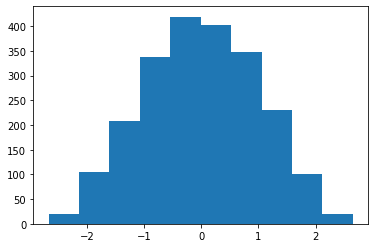

In [64]:
plt.hist(y_train[:,0])

(array([  5.,  26.,  83., 256., 728., 763., 253.,  54.,  16.,   3.]),
 array([-4.27711707, -3.41102719, -2.54493732, -1.67884744, -0.81275757,
         0.05333231,  0.91942218,  1.78551206,  2.65160193,  3.51769181,
         4.38378169]),
 <a list of 10 Patch objects>)

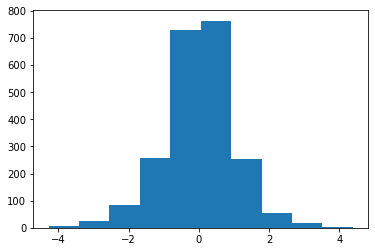

In [66]:
plt.hist(y_train[:,1])

## Test a simple sparse GP with no interaction between the outputs.

No interaction means we us no coregularization matrix and we can use either sklearn or GPy. 

I will just use RBF for now as I do not know better. Also, I will standardize the labels. 

### Predict Gibbs energy

In [100]:
K_simple = GPy.kern.Matern32(NFEAT) 
m_gibbs = GPy.models.SparseGPRegression(X_train, y_train[:,0].reshape(-1,1), 
                                                kernel=K_simple, num_inducing=500)

In [101]:
m_gibbs.optimize()

In [119]:
prediction = m_gibbs.predict(X_test)

Text(0, 0.5, 'normalized Gibbs free energy true')

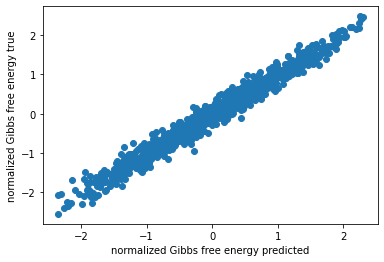

In [122]:
plt.scatter(prediction[0].reshape(-1,1), y_test[:,0].reshape(-1,1))
plt.xlabel('normalized Gibbs free energy predicted')
plt.ylabel('normalized Gibbs free energy true')

## Predict the virial

In [108]:
K_simple = GPy.kern.Matern32(NFEAT) 
m_virial = GPy.models.SparseGPRegression(X_train, y_train[:,1].reshape(-1,1), 
                                                kernel=K_simple, num_inducing=500)

In [109]:
m_virial.optimize()

In [111]:
prediction = m_virial.predict(X_test)

(-0.5, 0.5)

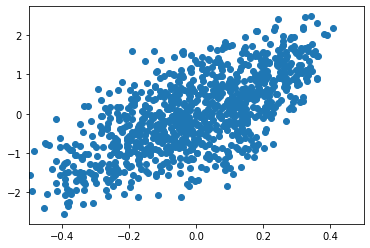

In [112]:
plt.scatter(prediction[0].reshape(-1,1), y_test[:,0].reshape(-1,1))
plt.xlim(-0.5,0.5)

## Test a simple sparse GP with coregionalization

I would expect that coregionalization helps as there is some common physics between the Gibbs energy and the virial ...

In [15]:
NFEAT = X_train.shape[1]

In [82]:
K = GPy.kern.Matern32(NFEAT) 
icm = GPy.util.multioutput.ICM(input_dim=NFEAT,num_outputs=2,kernel=K)
m = GPy.models.SparseGPCoregionalizedRegression([X_train, X_train], 
                                                [y_train[:,0].reshape(-1,1), y_train[:,1].reshape(-1,1)], 
                                                kernel=icm, num_inducing=500)

In [83]:
m

sparse_gp.,value,constraints,priors
inducing inputs,"(20, 20)",{fixed},
ICM.Mat32.variance,1.0,+ve,
ICM.Mat32.lengthscale,1.0,+ve,
ICM.B.W,"(2, 1)",,
ICM.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1.0,+ve,
mixed_noise.Gaussian_noise_1.variance,1.0,+ve,


In [84]:
m.optimize()

{'inducing': <matplotlib.collections.PathCollection at 0x127945940>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x12819c160>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x12819c240>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x127aea780>]}

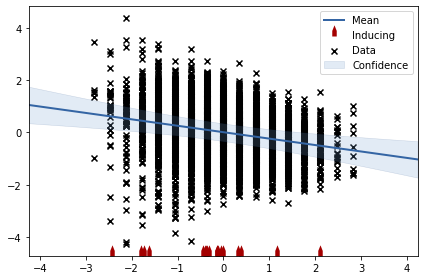

In [85]:
m.plot(visible_dims=[4])

In [86]:
m

sparse_gp.,value,constraints,priors
inducing inputs,"(20, 20)",{fixed},
ICM.Mat32.variance,0.027858432348310688,+ve,
ICM.Mat32.lengthscale,1219.173225430742,+ve,
ICM.B.W,"(2, 1)",,
ICM.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.029060934265526462,+ve,
mixed_noise.Gaussian_noise_1.variance,0.9767610000448267,+ve,


Strange how the inducing points are selected along some feature dimensions ... But nice how it works with little points ;)

### Predicting Gibbs

In [87]:
newX = np.hstack([X_test,0 * np.ones_like(X_test)])
mu, var =m.predict(newX,Y_metadata={'output_index':0 * np.ones((newX.shape[0],1)).astype(int)})

Text(0, 0.5, 'actual')

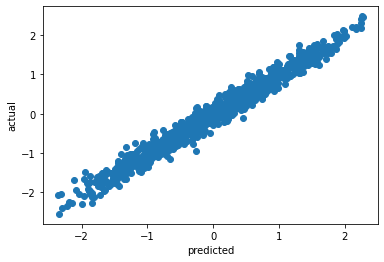

In [88]:
plt.scatter(mu1, y_test[:,0])
plt.xlabel('predicted')
plt.ylabel('actual')

The Gibbs energy prediction seems reasonable to me.

### Predicting Virial

In [89]:
newX = np.hstack([X_test, 1 * np.ones_like(X_test)])
mu, var =m.predict(newX,Y_metadata={'output_index': 1 * np.ones((newX.shape[0],1)).astype(int)})

(-0.5, 0.5)

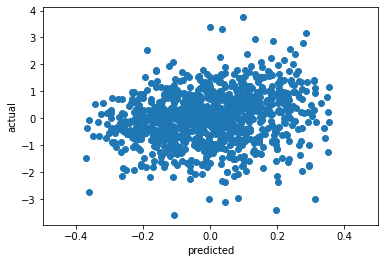

In [114]:
plt.scatter(mu, y_test[:,1])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.xlim(-0.5,0.5)

The virial seems really bad to me.

In [115]:
joblib.dump(m_gibbs, '../models/matern_gibbs.joblib')

['../models/matern_gibbs.joblib']

In [116]:
joblib.dump(m_virial, '../models/matern_virial.joblib')

['../models/matern_virial.joblib']

In [117]:
joblib.dump(m, '../models/coregionalized.joblib')

['../models/coregionalized.joblib']